<a href="https://colab.research.google.com/github/datle2403/datle2403/blob/main/Combining_different_model_for_esemble_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Idea of a simple majority vote classifier

Build a strong meta-classifier to balance out the individual classifier weakness.
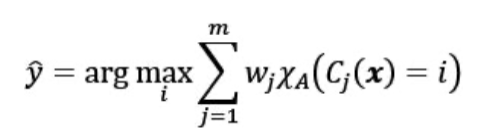

wj: weight associated with base classifier Cj, y^ is predicted class for esemble. Xa is a set of class label. Which return 1 if the predicted class of base classifier Cj match i.

For equal weight, we can write this.
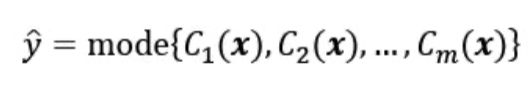

Example of weight:
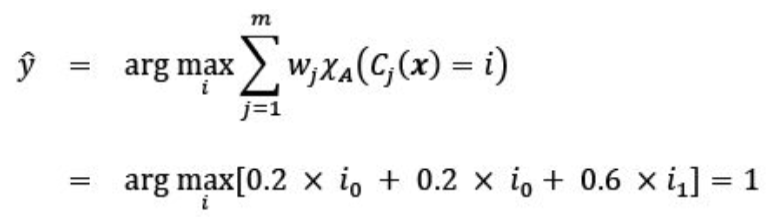

In [ ]:
import numpy as np
np.argmax(np.bincount([0,0,1],weights=[0.2,0.2,0.2]))

0

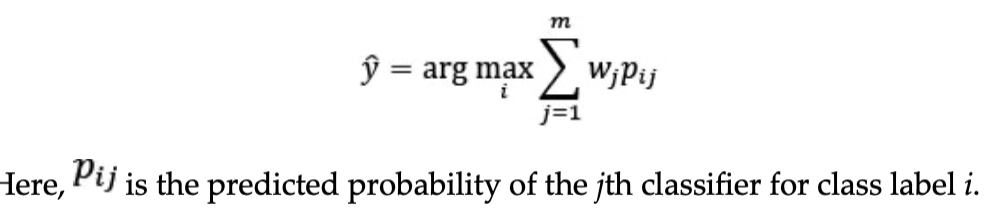

In [ ]:
ex=np.array([[0.2,0.8],[0.9,0.1],[0.6,0.4]])
p=np.average(ex,axis=0,weights=[0.2,0.2,0.6])
p

array([0.58, 0.42])

# Building MajorityVote Class and use Iris as example

BaseEstimator and ClassifierMixin parent classes to get some base functionality for free, including the get_params and set_params methods to set and return the classifier's parameters, as well as the score method to calculate the prediction accuracy.

In [24]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
from sklearn.preprocessing import LabelEncoder
import numpy as np
import operator
class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
  def __init__(self, classifiers, vote='classlabel', weights=None):

      self.classifiers = classifiers
      self.name_classifiers = {key: value for key, value in _name_estimators(classifiers)}
      self.vote = vote
      self.weights = weights
  def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

  def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
  def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
  def get_params(self, deep=True):
    """ Get classifier parameter names for GridSearch"""
    if not deep:
        return super(MajorityVoteClassifier, self).get_params(deep=False)
    else:
        out = self.name_classifiers.copy()
        for name, step in self.name_classifiers.items():
            for key, value in step.get_params(deep=True).items():
                out['%s__%s' % (name, key)] = value
        return out

In [25]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
iris=datasets.load_iris()
X,y=iris.data[50:,[1,2]],iris.target[50:]
le=LabelEncoder()
y=le.fit_transform(y)
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1,stratify=y,test_size=0.5)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
clf1=LogisticRegression(penalty='l2',solver='lbfgs',C=0.001,random_state=1)
clf2=DecisionTreeClassifier(max_depth=1,criterion='entropy',random_state=0)
clf3=KNeighborsClassifier(p=2,n_neighbors=1,metric='minkowski')
pipe1=Pipeline([['sc',StandardScaler()],['clf',clf1]])
pipe3=Pipeline([['sc',StandardScaler()],['clf',clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
for clf,label in zip([pipe1,clf2,pipe3],clf_labels):
  scores=cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,n_jobs=1,scoring='roc_auc')
  print('ROC auc: ',scores.mean(),'+-',scores.std(),' ',label)




ROC auc:  0.9166666666666666 +- 0.1536590742882148   Logistic regression
ROC auc:  0.8666666666666668 +- 0.18333333333333332   Decision tree
ROC auc:  0.85 +- 0.13333333333333333   KNN


ROC is a cure in graph, where x_axis is FPR( false positive rate), TPR(True Positive Rate).

In [27]:
mv_clf=MajorityVoteClassifier(classifiers=[pipe1,clf2,pipe3])
clf_labels+='Majority_voting'
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf,label in zip(all_clf,clf_labels):
  scores=cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,n_jobs=1,scoring='roc_auc')
  print('ROC auc: ',scores.mean(),'+-',scores.std(),' ',label)

ROC auc:  0.9166666666666666 +- 0.1536590742882148   Logistic regression
ROC auc:  0.8666666666666668 +- 0.18333333333333332   Decision tree
ROC auc:  0.85 +- 0.13333333333333333   KNN
ROC auc:  0.9833333333333334 +- 0.04999999999999999   M


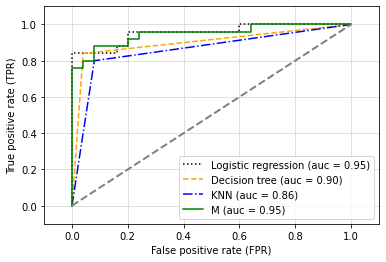

In [28]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('images/07_04', dpi=300)
plt.show()

However, you can see that the logistic regression classifier performs similarly well on the same dataset, which is probably due to the high variance (in this case, sensitivity of how we split the dataset) given the small size of the dataset:

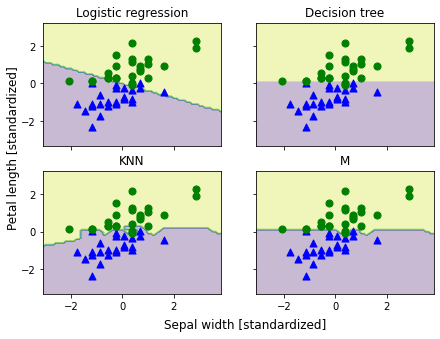

In [29]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

#plt.savefig('images/07_05', dpi=300)
plt.show()

In [30]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

Based on the values returned by the get_params method,

 we now know how to access the individual classifier's a ributes.